In [2]:
# ライブラリインポート
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict



def px_to_real(px, px_min, px_max, v_min, v_max,
               scale="linear", invert=False):
    """
    px       : pixel座標（配列OK）
    px_min   : pixel最小値
    px_max   : pixel最大値
    v_min    : 実値最小
    v_max    : 実値最大
    scale    : "linear" or "log"
    invert   : Trueなら軸方向を反転（例: y軸）
    """
    px = np.asarray(px, dtype=float)

    # 範囲外対策
    px = np.clip(px, px_min, px_max)

    # 0〜1 正規化
    t = (px - px_min) / (px_max - px_min)

    # 反転（y軸用）
    if invert:
        t = 1 - t

    if scale == "log":
        if v_min <= 0 or v_max <= 0:
            raise ValueError("log scale requires v_min > 0 and v_max > 0")

        log_v = np.log10(v_min) + t * (np.log10(v_max) - np.log10(v_min))
        return 10 ** log_v

    elif scale == "linear":
        return v_min + t * (v_max - v_min)

    else:
        raise ValueError("scale must be 'linear' or 'log'")


In [ ]:
# メイン処理
# GUIでユーザ入力から受け取る予定
X_MIN_INPUT = 0.5
X_MAX_INPUT = 3
Y_MIN_INPUT = 1
Y_MAX_INPUT = 1000
X_SCALE = "linear"
Y_SCALE = "log"
IMAGE_PATH = "10_test_data/VF_VS_IF.png"

def main():
		
	

	# 画像読み込み（OpenCVはBGR）
	img_bgr = cv2.imread(IMAGE_PATH)

	if img_bgr is None:
		raise FileNotFoundError("画像が読み込めへんで。パス確認してな。")

	# RGBに変換
	img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

	# img は RGB（numpy配列）前提
	gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

	
	# 反転二値化（線を白にする）
	_, bw = cv2.threshold(
		gray, 0, 255,
		cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
	)

	# 横線用カーネル（幅は画像サイズ依存）
	h_kernel = cv2.getStructuringElement(
		cv2.MORPH_RECT,
		(40, 1)   # ← 横に長い
	)
	horizontal_lines = cv2.morphologyEx(
		bw, cv2.MORPH_OPEN, h_kernel	
	)

	# 縦線用カーネル
	v_kernel = cv2.getStructuringElement(
		cv2.MORPH_RECT,
		(1, 40)   # ← 縦に長い
	)
	vertical_lines = cv2.morphologyEx(
		bw, cv2.MORPH_OPEN, v_kernel
	)

	# 縦横のグリッドを消す
	grid = cv2.bitwise_or(horizontal_lines, vertical_lines)

	# グリッドを除去
	bw_no_grid = cv2.subtract(bw, grid)


	# 連結成分解析(ノイズ除去)
	num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
		bw_no_grid, connectivity=8
	)

	# 面積しきい値（ここ要調整）
	MIN_AREA = 10

	clean = np.zeros_like(bw_no_grid)

	for i in range(1, num_labels):  # 0は背景
		area = stats[i, cv2.CC_STAT_AREA]
		if area >= MIN_AREA:
			clean[labels == i] = 255
	# ノイズ除去終了

	# 切れかけたグラフをつなぐ
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
	clean2 = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel)

	# 曲線　→　座標変換
	# 白ピクセル（曲線）の座標を取得
	ys, xs = np.where(clean2 > 0)
	points = np.column_stack((xs, ys))

	x_to_ys = defaultdict(list)

	for x, y in points:
		x_to_ys[x].append(y)

	curve_xy = []

	for x in sorted(x_to_ys.keys()):
		y_med = int(np.median(x_to_ys[x]))
		curve_xy.append((x, y_med))

	curve_xy = np.array(curve_xy)

	x_px = curve_xy[:,0] 
	y_px = curve_xy[:,1]


	# ROI座標系での端 
	x_px_min, x_px_max = 0, clean2.shape[1] 
	y_px_min, y_px_max = 0, clean2.shape[0]
	
	# ユーザ入力
	x_min, x_max = X_MIN_INPUT,X_MAX_INPUT
	y_min, y_max = Y_MIN_INPUT,Y_MAX_INPUT
	
	# x: 左→右が min→max
	x_real = px_to_real(x_px, x_px_min,x_px_max, x_min, x_max, scale=X_SCALE)
	# y: 上→下が max→min （ここがポイント）
	y_real = px_to_real(y_px, y_px_min,y_px_max, y_min, y_max, scale=Y_SCALE,invert=True)

	plt.figure(figsize=(6, 4))
	plt.plot(x_real, y_real, '-o', markersize=3)
	plt.xlabel("X")
	plt.ylabel("Y")
	plt.grid(True)
	plt.title("Calibrated Curve")
	plt.show()

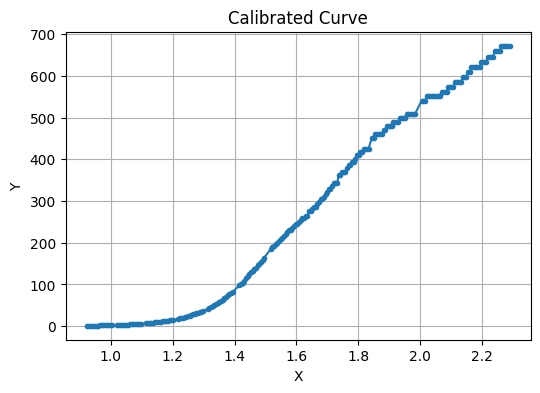

In [14]:
if __name__ == "__main__":
    main()